## **하이퍼 파라미터 튜닝**
작성자 : 남궁영수

early stopping 관련 참고 : https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0


---

하이퍼 파라미터
: 신경망 학습을 통해 최적화 해야하는 주 변수가 아니라, 사람들이 선험적지식으로 선정하거나 또는 실험을 통하여 선정되는 변수

---

대표적인 하이퍼 파라미터의 종류
1. 학습률 learning rate

기울기 방향으로 얼마나 빠르게 이동할 것인지 결정. 

너무 작으면 학습의 속도가 너무 느리고 너무 크면, 학습의 결과가 수렴이 안되고 진동할 수 있다.

학습 대상이나 망에 따라 적절하게 조정

2. 비용함수 cost function

평균제곱오차, 크로스 엔트로피

3. 정규화 파라미터 regularization parameter

regularization strength(λ) 

4. 배치 크기

64,128,256,512 등의 크기로


5. 은닉층 갯수, 은닉층의 뉴런 갯수

은닉층의 갯수가 많아질수록 특정 훈련 데이터에 더 최적화시킬 수 있음

은닉층의 뉴런의 갯수는 동일하게 유지하는 것이 효과적

첫 은닉층에 있는 뉴런의 갯수가 입력 변수 갯수보다 큰 것이 일반적



6. 활성화 함수 : sigmoid, tanh, Relu, Leakyrelu, Elu 등


7. 가중치 초기화 방법 : Xavier, He


8. 학습 반복 횟수

몇번 반복시킬지 or 어느 조건에서 학습을 멈춰줄지

9. 가중치 감소

L2 regularization, or L1 regularization

10. 최적화 함수

SGD, Momentum, Adagrad, RMSProp, Adam

---


# 하이퍼 파라미터 최적화 방법론:

### 1. 각 하이퍼 파라미터의 범위를 대략적으로 정한다.


### -고정 하이퍼파라미터 : 

비용함수는 크로스엔트로피 사용 (분류 문제에선, 일반적으로 크로스엔트로피를 사용하므로)

정규화파라미터 사용x (loss function 새로 만들어야 하는데, 구현시간 얼마나 걸릴지 모름)

가중치 초기화 벙법은 He (어차피 batch norm 을 사용할 것이기 때문에, 초기화 방법을 바꿔가며, 결과를 비교할 필요는 없을 것임)

학습 반복 횟수 : 전체는 100 epoch으로 하되, 중간에 early stopping(조기종료) 적용

가중치 감소는 사용x (loss function 새로 만들어야 하는데, 구현시간 얼마나 걸릴지 모름)

최적화함수(Adam, 일반적으로 가장 많이 쓰이고, 검증된 최적화방법이므로)

### --조작 하이퍼파라미터 : 
**학습률(=LEARNIN_RATE,  Adam 에 넣어줄 learning rate값) :  10^-2, 10^-3, 10^-4, 10^-5, 10^-6 --> 실제로 10^-6 나 10^-5, 10^-1은 해보니까 너무 느려서 학습이 안됨**

**이걸로 하자--> 10^-2, 5x10^-3, 10^-3, 5x10^-4, 10^-4**

배치크기 : 128, 256, 512, ...

은닉층 갯수 : 2층,3층,4층,5층, ...

각 은닉층의 뉴런 갯수 : 64, 128, 256, 512, ...

각 은닉층의 활성화 함수 : relu, gelu, tanh, sigmoid, ...


총 경우의 수:

5(학습률) x 3(배치크기) x 4(은닉층 갯수) x 4(각 은닉층의 뉴런 갯수) x 4(각 은닉층의 활성화 함수) 
=  960 가지


**전부 돌려볼 순 없으니까, 샘플링 하자!!**

### 2. 샘플링 단계 : 각 하이퍼파라미터의 범위내에서 무작위로 값을 골라낸다.
**한 사람당 여러 조합중에 --개의 조합 뽑기**

### 3. 학습 및 평가단계 : 샘플링한 하이퍼파라미터값을 가지고 학습하고, 검증데이터로 정확도를 평가한다.
**샘플링한 하이퍼파라미터값을 가지고 학습하고, 검증데이터로 정확도를 평가**

### 4. 위 2,3 단계를 여러번 수행한다.


### 5. 학습이 잘된 모델의 하이퍼파라미터 값을 확인할 후, 그 범위를 좁혀간다.


### 6. 어느 시점에서 종료한 후 하이퍼파라미터 값을 선택한다.

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

n_epochs = 100



################################################################################
#학습률(LEARNING_RATE) : 영수(), 비(), 예은(), 근영(), 정현()
# 1e-2
LEARNING_RATE = 1.0*1e-2


#배치크기(batch_size) : 128, 256, 512, ...
batch_size = 512
################################################################################

In [ ]:
def create_datasets(batch_size):
    # trainning set 중 validation 데이터로 사용할 비율
    valid_size = 0.2

    # torch.FloatTensor로 변환
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root = 'data', train = True,
                                download = True, transform = transform)
    test_data = datasets.MNIST(root = 'data', train = False,
                                download = True, transform = transform)

    # validation으로 사용할 trainning indices를 얻는다.
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # trainning, validation batch를 얻기 위한 sampler정의
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)

    return train_loader, test_loader, valid_loader

train_loader, test_loader, valid_loader = create_datasets(batch_size)

X_train: torch.Size([512, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([512]) type: torch.LongTensor


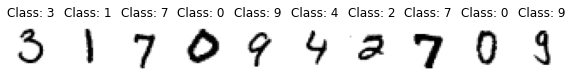

In [ ]:
'''  데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

'''  데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

################################################################################
#은닉층 갯수 : 2층,3층,4층,5층, ...
#각 은닉층의 뉴런 갯수 : 64, 128, 256, 512, ...
#각 은닉층의 활성화 함수 : relu, gelu, tanh, sigmoid, ...

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28*28, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 512)
        self.batch_norm2 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, 512)
        self.batch_norm3 = nn.BatchNorm1d(512)

        self.fc4 = nn.Linear(512, 512)
        self.batch_norm4 = nn.BatchNorm1d(512)

        self.fc5 = nn.Linear(512, 512)
        self.batch_norm5 = nn.BatchNorm1d(512)

        self.connected_to_output = nn.Linear(512,10)

        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # image input을 펼쳐준다.
        x = x.view(-1, 28*28)

        # 은닉층을 추가하고 활성화 함수로 gelu 사용
        x = F.gelu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)

        # 은닉층을 추가하고 활성화 함수로 gelu 사용
        x = F.gelu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)

        # 은닉층을 추가하고 활성화 함수로 gelu 사용
        x = F.gelu(self.batch_norm3(self.fc3(x)))
        x = self.dropout(x)

        # 은닉층을 추가하고 활성화 함수로 gelu 사용
        x = F.gelu(self.batch_norm4(self.fc4(x)))
        x = self.dropout(x)

        # 은닉층을 추가하고 활성화 함수로 gelu 사용
        x = F.gelu(self.batch_norm5(self.fc5(x)))
        x = self.dropout(x)

        # 출력층 추가
        x = self.connected_to_output(x)

        # Softmax !!! 안해줘도 됨. 어차피 CrossEntroyLoss에서 softmax해줌. https://junstar92.tistory.com/118
        x = F.log_softmax(x, dim = 1)

        return x
################################################################################


def weight_init(m):                       # He 초기화
  if isinstance(m, nn.Linear):            # He 초기화
    init.kaiming_uniform_(m.weight.data)  # He 초기화


#initialize the NN / 모델 확인
model = Net()
model.apply(weight_init)                # He 초기화
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (connected_to_output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# optimizer 정의(Adam)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, batch_size, patience, n_epochs):

    # 모델이 학습되는 동안 trainning loss를 track
    train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    valid_losses = []
    # epoch당 average training loss를 track
    avg_train_losses = []
    # epoch당 average validation loss를 track
    avg_valid_losses = []

    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()    
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data , target in valid_loader :
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print 학습/검증 statistics
        # epoch당 평균 loss 계산
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))


        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

   # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses





# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 10 # 단위는 epoch

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs) 

[  1/100] train_loss: 0.46482 valid_loss: 0.15761
Validation loss decreased (inf --> 0.157607).  Saving model ...
[  2/100] train_loss: 0.20829 valid_loss: 0.11809
Validation loss decreased (0.157607 --> 0.118093).  Saving model ...
[  3/100] train_loss: 0.16013 valid_loss: 0.10420
Validation loss decreased (0.118093 --> 0.104198).  Saving model ...
[  4/100] train_loss: 0.13290 valid_loss: 0.09812
Validation loss decreased (0.104198 --> 0.098121).  Saving model ...
[  5/100] train_loss: 0.11444 valid_loss: 0.08135
Validation loss decreased (0.098121 --> 0.081353).  Saving model ...
[  6/100] train_loss: 0.10158 valid_loss: 0.08351
EarlyStopping counter: 1 out of 10
[  7/100] train_loss: 0.08621 valid_loss: 0.07595
Validation loss decreased (0.081353 --> 0.075955).  Saving model ...
[  8/100] train_loss: 0.08102 valid_loss: 0.07732
EarlyStopping counter: 1 out of 10
[  9/100] train_loss: 0.07372 valid_loss: 0.07389
Validation loss decreased (0.075955 --> 0.073887).  Saving model ...
[ 

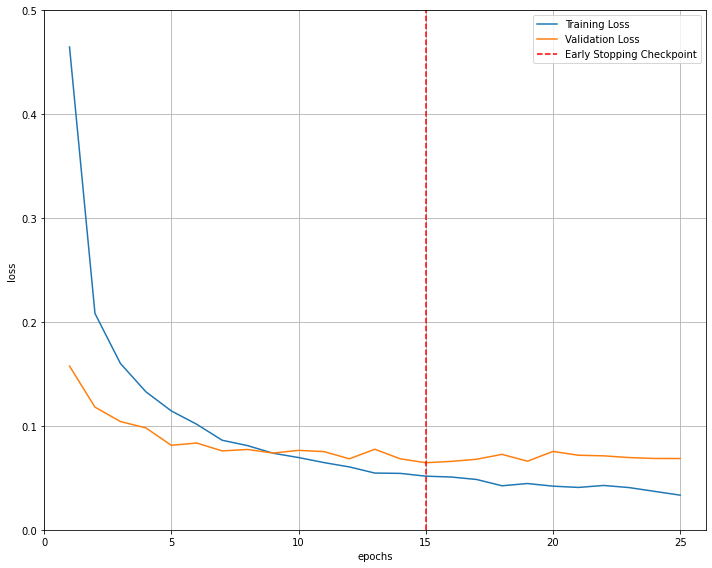

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [ ]:
# test loss 및 accuracy을 모니터링하기 위해 list 초기화
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader :
    if len(target.data) != batch_size:
        break

    # forward pass: 입력을 모델로 전달하여 예측된 출력 계산
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # 출력된 확률을 예측된 클래스로 변환
    _, pred = torch.max(output, 1)
    # 예측과 실제 라벨과 비교
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # 각 object class에 대해 test accuracy 계산
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] +=1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.3f%% (%2d/%2d)' % (
            str(i), 100.0 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.3f%% (%2d/%2d)' % (
    100.0 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.064379

Test Accuracy of     0: 98.741% (941/953)
Test Accuracy of     1: 99.275% (1095/1103)
Test Accuracy of     2: 98.807% (994/1006)
Test Accuracy of     3: 98.474% (968/983)
Test Accuracy of     4: 98.426% (938/953)
Test Accuracy of     5: 98.163% (855/871)
Test Accuracy of     6: 97.419% (906/930)
Test Accuracy of     7: 97.686% (971/994)
Test Accuracy of     8: 97.043% (919/947)
Test Accuracy of     9: 97.571% (964/988)

Test Accuracy (Overall): 98.181% (9551/9728)


In [ ]:
# validation loss 및 accuracy을 모니터링하기 위해 list 초기화
valid_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

model.eval() # prep model for evaluation

for data, target in valid_loader :
    if len(target.data) != batch_size:
        break

    # forward pass: 입력을 모델로 전달하여 예측된 출력 계산
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    valid_loss += loss.item()*data.size(0)
    # 출력된 확률을 예측된 클래스로 변환
    _, pred = torch.max(output, 1)
    # 예측과 실제 라벨과 비교
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # 각 object class에 대해 validation accuracy 계산
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] +=1

# calculate and print avg validation loss
valid_loss = valid_loss/len(valid_loader.dataset)
print('Validation Loss: {:.6f}\n'.format(valid_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Validation Accuracy of %5s: %.3f%% (%2d/%2d)' % (
            str(i), 100.0 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Validation Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nValidation Accuracy (Overall): %.3f%% (%2d/%2d)' % (
    100.0 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Validation Loss: 0.012881

Validation Accuracy of     0: 99.479% (1145/1151)
Validation Accuracy of     1: 98.695% (1286/1303)
Validation Accuracy of     2: 98.624% (1147/1163)
Validation Accuracy of     3: 97.575% (1207/1237)
Validation Accuracy of     4: 98.424% (1124/1142)
Validation Accuracy of     5: 98.053% (1007/1027)
Validation Accuracy of     6: 98.782% (1135/1149)
Validation Accuracy of     7: 98.042% (1252/1277)
Validation Accuracy of     8: 97.706% (1150/1177)
Validation Accuracy of     9: 97.913% (1126/1150)

Validation Accuracy (Overall): 98.327% (11579/11776)
